In [2]:
import os,shutil,subprocess


# source /home/artem/cp2k/tools/toolchain/install/setup
# /home/artem/cp2k/exe/local/cp2k.sopt -i cp2k.inp
CP2K_DIR = '/home/artem/cp2k/exe/local/'
WORK_DIR = '/home/artem/paracetamol/pure_cp2k'
TOP = 'paracetamol-orthorhombic.prmtop'
XYZ = 'paracetamol-orthorhombic.pdb'
INP = 'cp2k.inp'




os.chdir(WORK_DIR)
# try:
#     os.mkdir('test-notebook')
# except:
#     shutil.rmtree('test-notebook', ignore_errors=True)
#     os.mkdir('test-notebook')
# os.chdir('test-notebook')
# shutil.copyfile(os.path.join('../',TOP),TOP)
# shutil.copyfile(os.path.join('../',INP),INP)
# shutil.copyfile(os.path.join('../',XYZ),XYZ)

# p = subprocess.call(f'{os.path.join(CP2K_DIR,"cp2k.sopt")} -i cp2k.inp -o cp2k.out',shell=True)

print(0)


0


In [13]:
os.chdir('/home/artem/paracetamol/pure_cp2k/test')

template = []
with open('cp2k.inp','r') as inp:
    for line in inp:
        template.append(line)

alphas = [f'{0.1*i:.3f}' for i in range(0,11)]
alphas.insert(1,f'{0.05:.3f}')

for alpha in alphas:
    with open(f'cp2k-{alpha}.inp','w') as inp:
        for line in template:
            if '   PROJECT' in line:
                line = f'PROJECT PAM-{alpha}\n'
            if 'FORCE_SCALE' in line:
                line = f'       FORCE_SCALE {alpha}\n'
            inp.write(line)
    print(alpha)
    p = subprocess.call(f'{os.path.join(CP2K_DIR,"cp2k.sopt")} -i cp2k-{alpha}.inp -o cp2k-{alpha}.out',shell=True)
    







0.000
0.050
0.100
0.200
0.300
0.400
0.500
0.600
0.700
0.800
0.900
1.000


In [5]:
from multiprocessing import Pool
import os, subprocess, shutil

import xtb_IO

INP = 'cp2k.inp'
TOP = 'paracetamol-orthorhombic.prmtop'
TRJ = 'PAM-pos-1.xyz'

XYZ = 'structures.xyz'
WD = '/home/artem/HREMD/multi_opt/'

MAX_PROC = 12


def run_opt(i,xyz,top,trj,inp):
    optdir = f'opt-{i}'
    try:
        os.mkdir(optdir)
    except:
        shutil.rmtree(optdir, ignore_errors=True)
    shutil.copyfile(top,os.path.join(optdir,top))
    shutil.copyfile(inp,os.path.join(optdir,inp))
    os.chdir(optdir)
    with open('struc.xyz','w') as fo:
        fo.write(xyz)
    # subprocess.call('cp2k.sopt -i cp2k.inp -o cp2k.out', shell=True)
    popen = subprocess.Popen('cp2k.sopt -i cp2k.inp -o cp2k.out',shell=True)
    exitcode = popen.wait()
    if exitcode !=0:
        print(f'frame {i}: optimization is down!')
    else:
        print(f'frame {i}: Normal termination!')
        with open('struc-opt.xyz','w') as fo:
            xyzopt = xtb_IO.get_frame_xyz(trj,-1)
            fo.write(xyzopt)
    os.chdir('..')


os.chdir(WD)
n=0
structures = []
with open(XYZ,'r') as traj:
    while True:
        lines = []
        try:
            nat = int(traj.readline())
        except:
            if n==0:
                print('EOF reached or incorrect number of atoms!')
            else:
                print(f'Trajectory with {n} structures was read!')
            break
        comm = traj.readline()
        lines.append(f'{nat}\n')
        lines.append(f'Frame {n}\n')
        for i in range(nat):
            lines.append(traj.readline())
        struc = ''.join(lines)
        structures.append(struc)
        n+=1

with Pool(MAX_PROC) as pool:
    tasks = [(i,struc,TOP,TRJ,INP) for i,struc in enumerate(structures)]

    results = [pool.apply_async(run_opt, t) for t in tasks]


# for struc in structures:
    # proc = Process(target=run_opt, args=())

# with open('test.xyz','w') as fo:
#     fo.write(structures[0])









EOF reached or incorrect number of atoms!


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt

print(os.getcwd())

def read_ener(fname):
    steps = []
    pot_e = []
    kin_e = []
    temp = []
    with open(fname,'r') as fi:
        _ = fi.readline()
        while True:
            dat = fi.readline()
            if dat == '':
                break
            step,_,kin,t,pot,_,_ = dat.split()
            pot_e.append(float(pot))
            kin_e.append(float(kin))
            temp.append(float(t))
            steps.append(int(step))
    return steps, pot_e, kin_e, temp


steps, md, _, _ = read_ener('/home/artem/paracetamol/md/PAM-MD-1.ener')

print(min(md[-1000:-500]))
print(max(md[-1000:-500]))
print(sum(md[-1000:-500])/len(md[-1000:-500]))
print(len(md[-1000:-500]))

print(min(md))
print(max(md))
print(sum(md)/len(md))
print(len(md))

                
steps, pure1, _, _ = read_ener('PAM-1.ener')
_, pure_cc, _, _  = read_ener(os.path.abspath('center_xyz/PAM-1.ener'))
_, pure_vs, _, _ = read_ener(os.path.abspath('vel_soft/PAM-1.ener'))
_, mod1, _, _  = read_ener(os.path.abspath('reference/PAM-1.ener'))
_, mod2, _, _  = read_ener(os.path.abspath('reference_fixed/PAM-1.ener'))

_, mod005, _, _  = read_ener(os.path.abspath('0.05/mod/PAM-1.ener'))
_, mod001, _, _  = read_ener(os.path.abspath('0.01/mod/PAM-1.ener'))
_, mod01, _, _  = read_ener(os.path.abspath('0.1/mod/PAM-1.ener'))
_, mod05, _, _  = read_ener(os.path.abspath('0.5/mod/PAM-1.ener'))

#----------------- Histogramms -----------------#

fig, ax = plt.subplots()
num_bins = 100
n, bins, patches = ax.hist(mod1, num_bins, density=True,label='mod., default',alpha=0.5)
n, bins, patches = ax.hist(pure1, num_bins, density=True,label='pure, default',alpha=0.5)
# n, bins, patches = ax.hist(pure_cc, num_bins, density=True,label='pure, no $CENTER_POINT',alpha=0.7)
# n, bins, patches = ax.hist(pure_vs, num_bins, density=True,label='pure, no $VELOCITY_SOFTENING',alpha=0.7)

ax.set_xlabel('Total energy of structure, a.u.')
ax.set_ylabel('')
ax.set_title('Differences of modificated and pure CP2K')


#----------------- Trajectory -----------------#

fig, ax = plt.subplots()
# sizes = [1 for i in steps]

# ax.plot(steps, mod2, alpha=0.5)
# ax.plot(steps, pure1, alpha=0.5)
# ax.plot(steps, pure_cc, alpha=0.5)
# ax.plot(steps, pure_vs, alpha=0.5)

# ax.scatter(steps, mod2, s = 1, label='mod., fixed', alpha=0.8)
# ax.scatter(steps, pure1, s = 1, label='pure, default', alpha=0.8)
# ax.scatter(steps, pure_cc, s = 1, label='pure, no $CENTER_POINT', alpha=0.8)
# ax.scatter(steps, pure_vs, s = 1, label='pure, no $VELOCITY_SOFTENING', alpha=0.8)

ax.scatter(steps, mod001, s = 1, label='mod, a=0.01', alpha=0.8)
ax.scatter(steps, mod005, s = 1, label='mod., a=0.05', alpha=0.8)
ax.scatter(steps, mod01, s = 1, label='mod., a=0.1', alpha=0.8)
ax.scatter(steps, mod05, s = 1, label='mod., a=0.5', alpha=0.8)
ax.plot(steps, mod001, alpha=0.5)
ax.plot(steps, mod005, alpha=0.5)
ax.plot(steps, mod01, alpha=0.5)
ax.plot(steps, mod05, alpha=0.5)


ax.set_xlabel('Step number')
ax.set_ylabel('Total energy of structure, a.u.')
# ax.set_title('Differences of modificated and pure CP2K')
ax.set_title('Modificated CP2K with different alphas')


ax.legend()

fig.tight_layout()
plt.show()

print(0)



/home/artem/HREMD_algorithm
-1.589085938
-1.353105625
-1.5152132179819995
500
-1.656177704
-0.59500046
-1.5227593354534195
2501


/home/artem/HREMD
NO OPT, VS
-1.591982413
-1.462946577
-1.5298157496340017
1000
dE max:
80.97121293044194


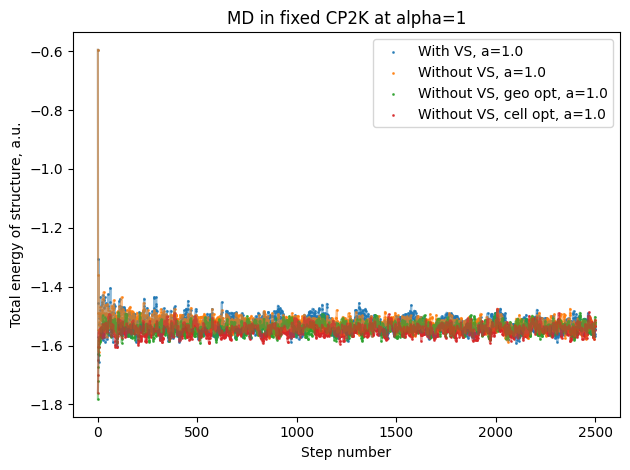

NO OPT, NO VS
-1.586518213
-1.47503939
-1.5320043556779992
1000
-1.621577349
-0.59500046
-1.5256131830927626
2501
dE max:
69.95402048131844
WITH GEOMETRY OPT
-1.582703773
-1.488282501
-1.539030170644
1000
-1.782557775
-1.486847381
-1.5408906304858074
2501
dE max:
59.250245182083965
WITH CELL OPT
-1.591181184
-1.474827847
-1.5459940768250013
1000
-1.760021172
-1.474827847
-1.5470627362423064
2501
dE max:
73.01282432420153


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

print(os.getcwd())

def read_ener(fname):
    steps = []
    pot_e = []
    kin_e = []
    temp = []
    with open(fname,'r') as fi:
        _ = fi.readline()
        while True:
            dat = fi.readline()
            if dat == '':
                break
            step,_,kin,t,pot,_,_ = dat.split()
            pot_e.append(float(pot))
            kin_e.append(float(kin))
            temp.append(float(t))
            steps.append(int(step))
    return steps, pot_e, kin_e, temp


steps, md, _, _ = read_ener('/home/artem/paracetamol/md/PAM-MD-1.ener')
steps, md2, _, _ = read_ener('/home/artem/paracetamol/md/PAM-MD-NO_VS-1.ener')
steps, md3, _, _ = read_ener('/home/artem/paracetamol/md/PAM-MD-OPT-1.ener')
steps, md4, _, _ = read_ener('/home/artem/paracetamol/md/PAM-MD-CELLOPT-1.ener')

print('NO OPT, VS')
print(min(md[-1000:]))
print(max(md[-1000:]))
print(sum(md[-1000:])/len(md[-1000:]))
print(len(md[-1000:]))

# print(min(md))
# print(max(md))
# print(sum(md)/len(md))
# print(len(md))

print('dE max:')
print((max(md[-1000:])-min(md[-1000:]))*627.5095)

fig, ax = plt.subplots()


ax.scatter(steps, md, s = 1, label='With VS, a=1.0', alpha=0.8)
ax.scatter(steps, md2, s = 1, label='Without VS, a=1.0', alpha=0.8)
ax.scatter(steps, md3, s = 1, label='Without VS, geo opt, a=1.0', alpha=0.8)
ax.scatter(steps, md4, s = 1, label='Without VS, cell opt, a=1.0', alpha=0.8)
ax.plot(steps, md, alpha=0.5)
ax.plot(steps, md2, alpha=0.5)
ax.plot(steps, md3, alpha=0.5)
ax.plot(steps, md4, alpha=0.5)


ax.set_xlabel('Step number')
ax.set_ylabel('Total energy of structure, a.u.')
ax.set_title('MD in fixed CP2K at alpha=1')


ax.legend()

fig.tight_layout()
plt.show()

print('NO OPT, NO VS')

print(min(md2[-1000:]))
print(max(md2[-1000:]))
print(sum(md2[-1000:])/len(md2[-1000:]))
print(len(md2[-1000:]))

print(min(md2))
print(max(md2))
print(sum(md2)/len(md2))
print(len(md2))

print('dE max:')
print((max(md2[-1000:])-min(md2[-1000:]))*627.5095)

print('WITH GEOMETRY OPT')

print(min(md3[-1000:]))
print(max(md3[-1000:]))
print(sum(md3[-1000:])/len(md3[-1000:]))
print(len(md3[-1000:]))

print(min(md3))
print(max(md3))
print(sum(md3)/len(md3))
print(len(md3))

print('dE max:')
print((max(md3[-1000:])-min(md3[-1000:]))*627.5095)

print('WITH CELL OPT')
print(min(md4[-1000:]))
print(max(md4[-1000:]))
print(sum(md4[-1000:])/len(md4[-1000:]))
print(len(md4[-1000:]))

print(min(md4))
print(max(md4))
print(sum(md4)/len(md4))
print(len(md4))

print('dE max:')
print((max(md4[-1000:])-min(md4[-1000:]))*627.5095)


